# Baseline: CNN with FFs/MolDs

### Load data

In [2]:
'Set the file name of your data'
data_name = "CYP450.csv.gz"

In [3]:
import numpy as np
import pandas as pd

data = pd.read_csv("../../../data/" + data_name, compression='gzip')

Set up (adapt according to your data)

In [4]:
# keep desired columns
data = data[['smiles', 'label_2c9']]

# drop molecules with NaN activity
data = data.dropna(subset = ["label_2c9"])

# set SMILES
smi = data['smiles'].tolist()

# set Y
Y = pd.get_dummies(data['label_2c9']).values

# number of active and inactive molecules
print("Inactive (0):", Y[:,1].tolist().count(0))
print("Active (1):", Y[:,1].tolist().count(1))

Inactive (0): 7429
Active (1): 2621


### Compute Fmaps for FFs or MolDs

In [5]:
'Compute the Fmaps for FFs or MolDs. Choose only one of both.'
desc = "FFs"
# desc = "MolDs"

In [6]:
import pickle
from pathlib import Path
from molmap import MolMap
from molmap import feature
from ondiskxy import MatrixWriter, MatrixReader
from ondiskxy.utils import chunker
import os.path
from os import path

dir_path_X1 = "../../../files/" + data_name + "/molmap/X1/X1"
dir_path_X2 = "../../../files/" + data_name + "/molmap/X2/X2"

# compute Fmaps for MolDs
if desc == "MolDs":
    if path.isdir(dir_path_X1):
        'If it exists, we load it.'
        reader = MatrixReader(dir_path=dir_path_X1)
        X1 = reader.read()

        for row in reader.iterrows():
            row

    else: 
        'Otherwise, we compute it and save it to disk.'
        # compute MolDs
        mp1 = MolMap(ftype='descriptor', metric='cosine',)
        mp1.fit(verbose=0, method='umap', min_dist=0.1, n_neighbors=15)

        # get Fmaps
        writer = MatrixWriter(dir_path=dir_path_X1, max_file_size_mb=1000)
        for smiles_chunk in chunker(smi, 10000):
            X1 = mp2.batch_transform(smiles_chunk)
            writer.append(X1)
        
# or compute Fmaps for FFs
elif desc == "FFs":        
    if path.isdir(dir_path_X2):
        'If it exists, we load it.'
        reader = MatrixReader(dir_path=dir_path_X2)
        X2 = reader.read()

        for row in reader.iterrows():
            row

    else: 
        'Otherwise, we compute it and save it to disk.'
        # compute FFs
        bitsinfo = feature.fingerprint.Extraction().bitsinfo
        flist = bitsinfo[bitsinfo.Subtypes.isin(['PubChemFP', 'MACCSFP', 'PharmacoErGFP'])].IDs.tolist()
        mp2 = MolMap(ftype = 'fingerprint', fmap_type = 'scatter', flist = flist) 
        mp2.fit(method = 'umap',  min_dist = 0.1, n_neighbors = 15, verbose = 0)
    
        # get Fmaps
        writer = MatrixWriter(dir_path=dir_path_X2, max_file_size_mb=1000)
        for smiles_chunk in chunker(smi, 10000):
            X2 = mp2.batch_transform(smiles_chunk)
            writer.append(X2)

In [7]:
if desc == "MolDs":
    X = X1
elif desc == "FFs":
    X = X2

### Split in train and test sets

In [8]:
import sys
sys.path.append("../../../src")
from utils import Rdsplit

train_idx, valid_idx, test_idx = Rdsplit(data, random_state = 888, split_size = [0.9, 0, 0.1])

9045 0 1005


In [9]:
trainX = X[train_idx]
trainY = Y[train_idx]
testX = X[test_idx]
testY = Y[test_idx]

### Set parameters and build Model (CNN)

In [10]:
from tensorflow.keras import layers
from tensorflow import keras

num_classes = trainY.shape[1]
input_shape = X.shape[1:]

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 70, 70, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3

In [11]:
batch_size = 128
epochs = 50

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.AUC()])

### Train model

First, compute sample weight.

In [12]:
from utils import sample_weight

sw = sample_weight(trainY[:,1])

In [13]:
model.fit(trainX, trainY, batch_size=batch_size, epochs=epochs, validation_split=0.11, sample_weight=sw)

Train on 8050 samples, validate on 995 samples
Epoch 1/50
8050/8050 [==============================] - 3s 425us/sample - loss: 0.8190 - auc: 0.7828 - val_loss: 0.6817 - val_auc: 0.8537
Epoch 2/50
8050/8050 [==============================] - 1s 165us/sample - loss: 0.7041 - auc: 0.8513 - val_loss: 0.6899 - val_auc: 0.8014
Epoch 3/50
8050/8050 [==============================] - 1s 165us/sample - loss: 0.6716 - auc: 0.8640 - val_loss: 0.6407 - val_auc: 0.8977
Epoch 4/50
8050/8050 [==============================] - 1s 166us/sample - loss: 0.6505 - auc: 0.8744 - val_loss: 0.6375 - val_auc: 0.8507
Epoch 5/50
8050/8050 [==============================] - 1s 165us/sample - loss: 0.6348 - auc: 0.8818 - val_loss: 0.6236 - val_auc: 0.8883
Epoch 6/50
8050/8050 [==============================] - 1s 166us/sample - loss: 0.6173 - auc: 0.8858 - val_loss: 0.6209 - val_auc: 0.8983
Epoch 7/50
8050/8050 [==============================] - 1s 168us/sample - loss: 0.6212 - auc: 0.8874 - val_loss: 0.6089 - val

<AxesSubplot:title={'center':'Performance Learning Curve'}>

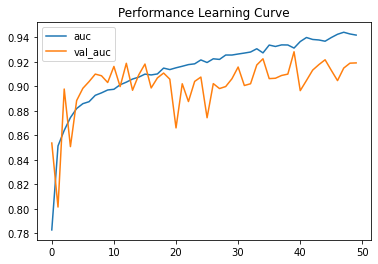

In [14]:
pd.DataFrame(model.history.history)[['auc', 'val_auc']].plot(title="Performance Learning Curve")

<AxesSubplot:title={'center':'Optimization Learning Curve'}>

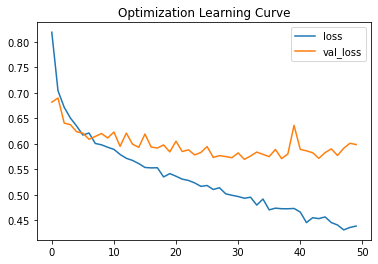

In [15]:
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot(title="Optimization Learning Curve")

In [16]:
score = model.evaluate(testX, testY, verbose=0)

print("Test AUC:", round(score[1], 3))

Test AUC: 0.9
